In [33]:
# import all necessary packages
import os, sys
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from IPython import display
from pathlib import Path
from keras import layers
import cv2
from sklearn.utils import shuffle
import math

from matplotlib import pyplot as plt
import seaborn as sns

(71, 71, 3)


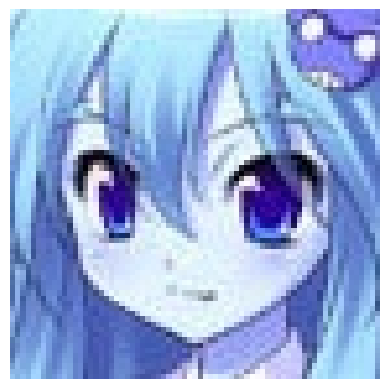

In [3]:
BASE_PATH = r"D:\Datasets\Anime Face Dataset\images"
dirs = os.listdir(BASE_PATH)

from random import randint
def plot_image():
    image = next(get_image_generator())
    image = cv2.imread(image)
    print(image.shape)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def get_image_generator():
    i = randint(0, len(dirs)-1)
    image = f"{BASE_PATH}/{dirs[i]}"
    yield image

plot_image()

In [4]:
BUFFER_SIZE = 2000
BATCH_SIZE = 128
codings_size = 100

In [47]:
# 256x256x3 generator
generator = keras.Sequential([layers.Input(shape=(100,)),
                              layers.Dense(4*4*256),
                              layers.BatchNormalization(),
                              layers.ReLU(),
                              layers.Reshape((4,4,256)),

                              layers.Conv2DTranspose(128, kernel_size=4, padding='same', strides=2),
                              layers.BatchNormalization(),
                              layers.ReLU(),

                              layers.Conv2DTranspose(64, kernel_size=4, padding='same', strides=2),
                              layers.BatchNormalization(),
                              layers.ReLU(),

                              layers.Conv2DTranspose(32, kernel_size=4, padding='same', strides=2),
                              layers.BatchNormalization(),
                              layers.ReLU(),
    
                              layers.Conv2DTranspose(3, kernel_size=4, padding='same', strides=2),
                              layers.Activation('sigmoid')], name="Generator")

In [48]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 4096)              413696    
                                                                 
 batch_normalization_59 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 4096)              0         
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 8, 8, 128)        524416    
 Transpose)                                                      
                                                                 
 batch_normalization_60 (Bat  (None, 8, 8, 128)        51

In [49]:
# discriminator, use leaky relu due to it being more appropriate (empricially tested)
discriminator = keras.Sequential([
                                 layers.Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding='same'),
                                 layers.BatchNormalization(),
                                 layers.LeakyReLU(alpha=0.2),
                                 layers.Dropout(0.3),
                                 
                                 layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
                                 layers.ZeroPadding2D(padding=((0,1),(0,1))),
                                 layers.BatchNormalization(momentum = 0.7),
                                 layers.LeakyReLU(alpha=0.2),
                                 layers.Dropout(0.3),

                                 layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
                                 layers.BatchNormalization(momentum = 0.7),
                                 layers.LeakyReLU(alpha=0.2),
                                 layers.Dropout(0.3),

                                 layers.Conv2D(256, kernel_size=3, strides=1, padding='same'),
                                 layers.BatchNormalization(momentum = 0.7),
                                 layers.LeakyReLU(alpha=0.2),
                                 layers.Dropout(0.3),

                                 layers.Flatten(),
                                 layers.Dense(1)], name="Discriminator")

In [50]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_63 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_40 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_10 (ZeroPadd  (None, 17, 17, 64)       0         
 ing2D)                                              

In [38]:
image_shape = (64,64,3)
discriminatorr = keras.Sequential()
discriminatorr.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
discriminatorr.add(layers.LeakyReLU(alpha=0.2))
discriminatorr.add(layers.Dropout(0.25))
discriminatorr.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminatorr.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
discriminatorr.add(layers.BatchNormalization(momentum=0.8))
discriminatorr.add(layers.LeakyReLU(alpha=0.2))
discriminatorr.add(layers.Dropout(0.25))
discriminatorr.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminatorr.add(layers.BatchNormalization(momentum=0.8))
discriminatorr.add(layers.LeakyReLU(alpha=0.2))
discriminatorr.add(layers.Dropout(0.25))
discriminatorr.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminatorr.add(layers.BatchNormalization(momentum=0.8))
discriminatorr.add(layers.LeakyReLU(alpha=0.2))
discriminatorr.add(layers.Dropout(0.25))
discriminatorr.add(layers.Flatten())
discriminatorr.add(layers.Dense(1))

In [39]:
discriminatorr.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_32 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_8 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_48 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                     

In [51]:
dataset = keras.utils.image_dataset_from_directory(
  BASE_PATH,
  label_mode=None,
  seed=42,
  image_size=(64,64), #resize to 64 for lower computing time
  batch_size=BATCH_SIZE)

dataset = dataset.map(lambda x: (x/255))

Found 63565 files belonging to 1 classes.


(64, 64, 3)
128


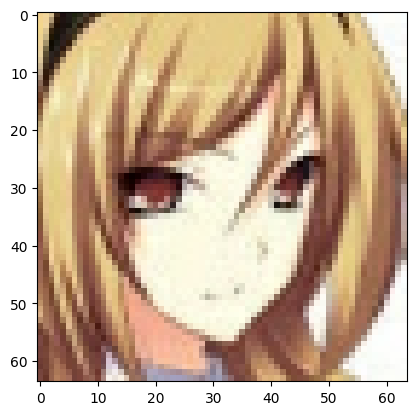

In [52]:
for batch in dataset:
    plt.imshow(batch[0])
    print(batch[0].shape)
    print(len(batch))
    break

In [12]:
list_ds = tf.data.Dataset.list_files(str(f"{BASE_PATH}\*"), shuffle=False)

for file in list_ds.take(5):
    file_name = str(file.numpy()).split(r"\\")[-1].replace("'","")
    print(file_name)

0_2000.jpg
10000_2004.jpg
10001_2004.jpg
10002_2004.jpg
10003_2004.jpg


In [13]:
fetch = False

In [14]:
from typing import Tuple

if not os.path.exists('gelbooru_images'):
    os.makedirs('gelbooru_images')

def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

# Create gelbooru_images directory where all images are 256x256 incase they were not from the scraper
if fetch:
    for post in list_ds:
        try:
            filename = str(post.numpy()).split(r"\\")[-1].replace("'","")
            img = Image.open(post.numpy())
            img = resize_with_pad(np.asarray(img), [256, 256]) # turns img to an np.array
            img = Image.fromarray(img) # converts back np.array to img
            img = img.save(f"gelbooru_images/{filename}")
        except:
            continue

In [15]:
# Same as previous one, but this time loads in 256x256 images
DS_PATH = "D:\Datasets\Anime Face Dataset\images"

list_ds = tf.data.Dataset.list_files(str(f"{DS_PATH}\*"), shuffle=False)
print(list_ds)

for file in list_ds.take(5):
    file_name = str(file.numpy()).split(r"\\")[-1].replace("'","")
    print(file_name)

image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False) #shuffle data


<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
0_2000.jpg
10000_2004.jpg
10001_2004.jpg
10002_2004.jpg
10003_2004.jpg


In [16]:
#Split the data into 80/20 train test split
test_size = int(image_count * 0.2)
train_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

In [17]:
train_class = True

In [18]:
IMG_SIZE = 64
class_names = ["train", "test"]
def load_image(image_path):
    if train_class:
        label = 0
    else:
        label = 1
    # load image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3) 
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255)# in the range [0,1], use sigmoid instead of tanh for generator
    
    return image


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
train_class = False
test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)

train_ds

<ParallelMapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>

In [20]:
#for image, label in train_ds.take(1):
for image in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  #print("label is: ", label.numpy())

Image shape:  (64, 64, 3)


In [21]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
    
train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

print(train_ds)

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


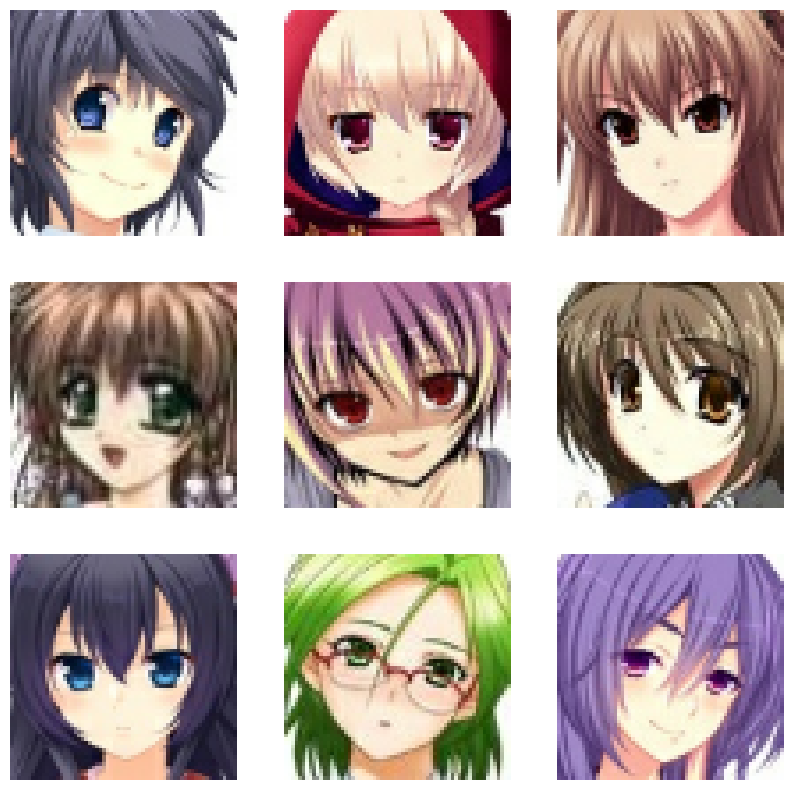

In [22]:
#image_batch, label_batch = next(iter(train_ds))
#image_test_batch, label_test_batch = next(iter(test_ds))

#print(image_batch.numpy().shape[0])
#print(image_test_batch.numpy().shape[0])
image_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("float64")) #use float32 or 64 since it's normalized thus in range [0, 1], otherwise uint8 since it would be in range [0, 255]
  #label = label_batch[i]
  #plt.title(class_names[label])
  plt.axis("off")

plt.show()

Helper Functions

In [53]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real,fake):
  real_loss = loss(tf.ones_like(real),real)
  fake_loss = loss(tf.zeros_like(fake),fake)
  return real_loss + fake_loss

def generator_loss(fake):
  gen_loss = loss(tf.ones_like(fake),fake)
  return gen_loss

generator_optimizer = keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = keras.optimizers.Adam(0.0002,0.5)

In [54]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,codings_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [55]:
def train(dataset, epochs):
  gen_loss=0
  dis_loss=0
  gen_plot = []
  dis_plot = []
  for epoch in range(epochs):
    print(f'{epoch+1} of {epochs}',end = ' ')
    print(f'generator loss is {gen_loss} and discriminator loss is {dis_loss}')
    for image_batch in dataset: 
      gen_loss,dis_loss = train_step(image_batch)
    gen_plot.append(gen_loss)
    dis_plot.append(dis_loss)
  x = [X for X in range(epochs)]
  plt.plot(x,gen_plot)
  plt.plot(x,dis_plot)
  plt.title('epoch vs loss')
  plt.legend(['gen_loss','dis_loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

In [56]:
tf.config.run_functions_eagerly(True)

1 of 5 generator loss is 0 and discriminator loss is 0
2 of 5 generator loss is 0.28284186124801636 and discriminator loss is 2.1463372707366943
3 of 5 generator loss is 0.18207043409347534 and discriminator loss is 2.5200021266937256
4 of 5 generator loss is 0.15006990730762482 and discriminator loss is 2.7043490409851074
5 of 5 generator loss is 0.1398753970861435 and discriminator loss is 2.7682392597198486


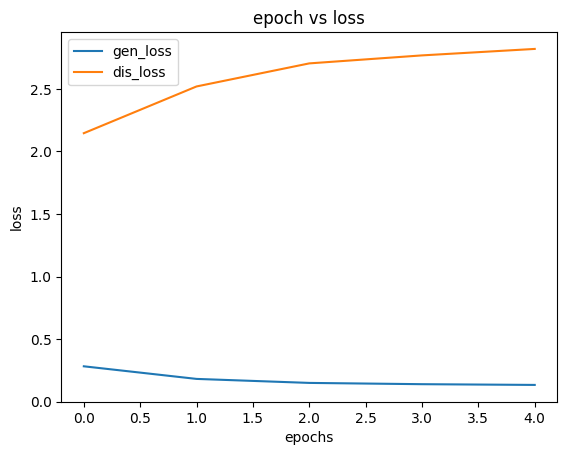

In [28]:
train(train_ds,5)

1 of 5 generator loss is 0 and discriminator loss is 0
2 of 5 generator loss is 3.94267201423645 and discriminator loss is 0.3261871933937073
3 of 5 generator loss is 3.2398393154144287 and discriminator loss is 0.6406573057174683
4 of 5 generator loss is 4.332758903503418 and discriminator loss is 0.6922773122787476
5 of 5 generator loss is 1.8584966659545898 and discriminator loss is 0.723486602306366


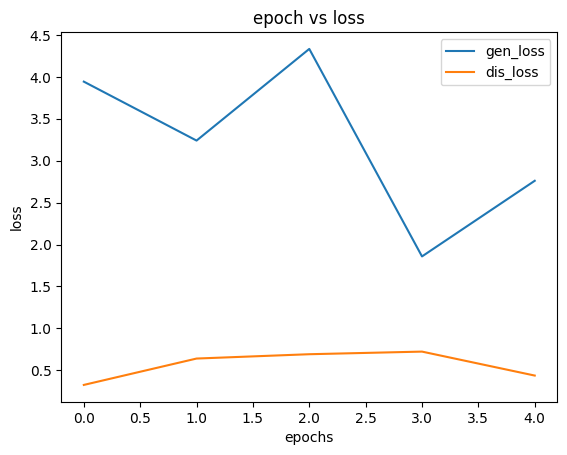

In [57]:
train(dataset, 5)

From the graph, we can see there is some overfitting in the model

In [58]:

noise = np.random.randn(32,100)
pred = generator.predict(noise)

1/1 [==============================] - 0s 77ms/step


c:\Users\janne\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


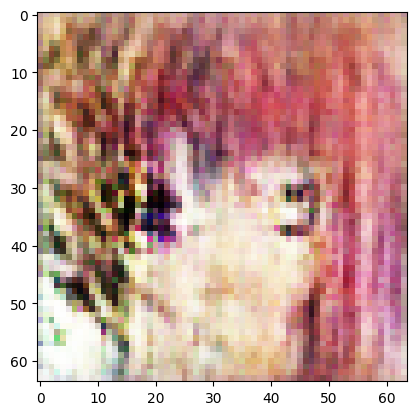

In [59]:
plt.imshow(pred[0])

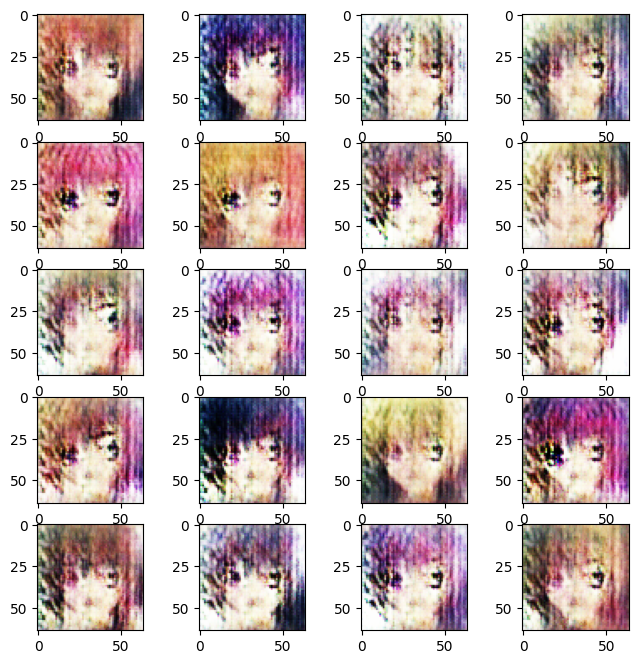

In [60]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()